In [1]:
import numpy as np
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import pickle, json

# Add the parent directory so that the 'scripts' folder is on the path
sys.path.append(os.path.join(os.getcwd(), "..")) 
from API.model.Non_LinearSVC import RBFKernelSVM
from API.scripts.evaluate import ModelEvaluator

In [2]:
BASE_DIR = r"..\API\data\processed"
train_path = os.path.join(BASE_DIR, "train_data.csv")
test_path = os.path.join(BASE_DIR, "test_data.csv")
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

target_column = train_data.columns[-1]  
X_train = train_data.drop(columns=[target_column]).values
y_train = train_data[target_column].values

X_test = test_data.drop(columns=[target_column]).values
y_test = test_data[target_column].values

In [3]:
max_train_samples = 5000  
if X_train.shape[0] > max_train_samples:
    
    # Ensure balanced sampling
    class_indices = {}
    for cls in np.unique(y_train):
        class_indices[cls] = np.where(y_train == cls)[0]
    
    # Calculate samples per class
    samples_per_class = max_train_samples // len(class_indices)
    
    # Sample indices
    sampled_indices = []
    for cls, indices in class_indices.items():
        if len(indices) > samples_per_class:
            sampled_indices.extend(np.random.choice(indices, samples_per_class, replace=False))
        else:
            sampled_indices.extend(indices)
    
    # Create subset
    X_train_subset = X_train[sampled_indices]
    y_train_subset = y_train[sampled_indices]
    

else:
    X_train_subset = X_train
    y_train_subset = y_train

# Train the custom RBF Kernel SVM
improved_rbf_svm = RBFKernelSVM(
    C=100.0,      
    gamma=0.001, 
    max_iter=100, 
    tol=1e-3      
)

loss_history = improved_rbf_svm.train(X_train_subset, y_train_subset, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 10, objective: 5901851.324302, changed alphas: 911
Iteration 20, objective: 15792870.037100, changed alphas: 917
Iteration 30, objective: 23169690.111177, changed alphas: 957
Iteration 40, objective: 28028519.363013, changed alphas: 1032
Iteration 50, objective: 33134619.029601, changed alphas: 960
Iteration 60, objective: 38095352.799945, changed alphas: 981
Iteration 70, objective: 45697320.864119, changed alphas: 919
Iteration 80, objective: 49738734.873484, changed alphas: 972
Iteration 90, objective: 54936892.791108, changed alphas: 884


  0%|          | 0/100 [00:23<?, ?it/s]

Iteration 100, objective: 57463937.004941, changed alphas: 897


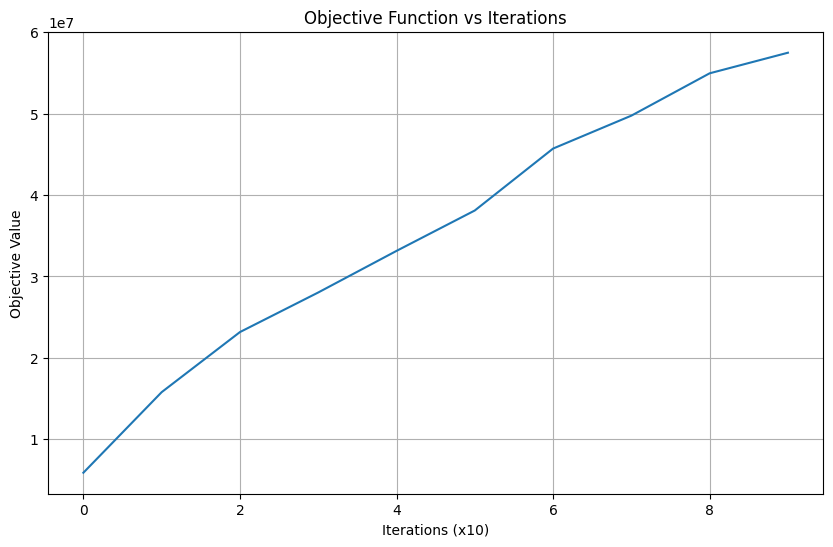

In [4]:
if loss_history:
        plt.figure(figsize=(10, 6))
        plt.plot(loss_history)
        plt.title('Objective Function vs Iterations')
        plt.xlabel('Iterations (x10)')
        plt.ylabel('Objective Value')
        plt.grid(True)
        plt.show()

In [5]:
improved_predictions = improved_rbf_svm.predict(X_test)
improved_accuracy = accuracy_score(y_test, improved_predictions)

In [6]:
print(classification_report(y_test, improved_predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2368
           1       0.99      0.99      0.99      2671

    accuracy                           0.99      5039
   macro avg       0.99      0.99      0.99      5039
weighted avg       0.99      0.99      0.99      5039



In [7]:
improved_cm = confusion_matrix(y_test, improved_predictions)

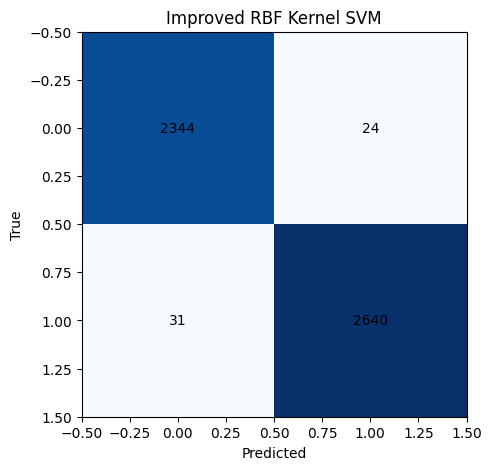

In [9]:

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))

im1 = ax1.imshow(improved_cm, cmap='Blues')
ax1.set_title('Improved RBF Kernel SVM')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
for i in range(improved_cm.shape[0]):
    for j in range(improved_cm.shape[1]):
        ax1.text(j, i, improved_cm[i, j], ha="center", va="center", color="black")

In [ ]:

# Define parameter grid
gamma_values = [0.001, 0.01, 0.1, 1.0]
C_values = [0.1, 1.0, 10.0, 100.0]

# Store results
results = []

# Iterate through parameter combinations
for gamma in gamma_values:
    for C in C_values:
        print(f"Testing gamma={gamma}, C={C}")
        
        # Create and train model
        model = RBFKernelSVM(
            C=C,
            gamma=gamma,
            max_iter=50  # Reduced for grid search
        )
        
        model.train(X_train_subset, y_train_subset)
        
        # Evaluate
        accuracy = model.score(X_test, y_test)
        results.append({
            'gamma': gamma,
            'C': C,
            'accuracy': accuracy
        })
        
        print(f"Accuracy: {accuracy:.4f}")

Testing gamma=0.001, C=0.1
Accuracy: 0.9575
Testing gamma=0.001, C=1.0
Accuracy: 0.9802
Testing gamma=0.001, C=10.0
Accuracy: 0.9869
Testing gamma=0.001, C=100.0
Accuracy: 0.9905
Testing gamma=0.01, C=0.1
Accuracy: 0.9393
Testing gamma=0.01, C=1.0
Accuracy: 0.9808
Testing gamma=0.01, C=10.0
Accuracy: 0.9857
Testing gamma=0.01, C=100.0
Accuracy: 0.9863
Testing gamma=0.1, C=0.1
Accuracy: 0.8637
Testing gamma=0.1, C=1.0
Accuracy: 0.9649
Testing gamma=0.1, C=10.0
Accuracy: 0.9684
Testing gamma=0.1, C=100.0
Accuracy: 0.9686
Testing gamma=1.0, C=0.1
Accuracy: 0.6825
Testing gamma=1.0, C=1.0
Accuracy: 0.8976
Testing gamma=1.0, C=10.0
Accuracy: 0.9246
Testing gamma=1.0, C=100.0
Accuracy: 0.9244



Best parameters:
Gamma: 0.001
C: 100.0
Accuracy: 0.9905


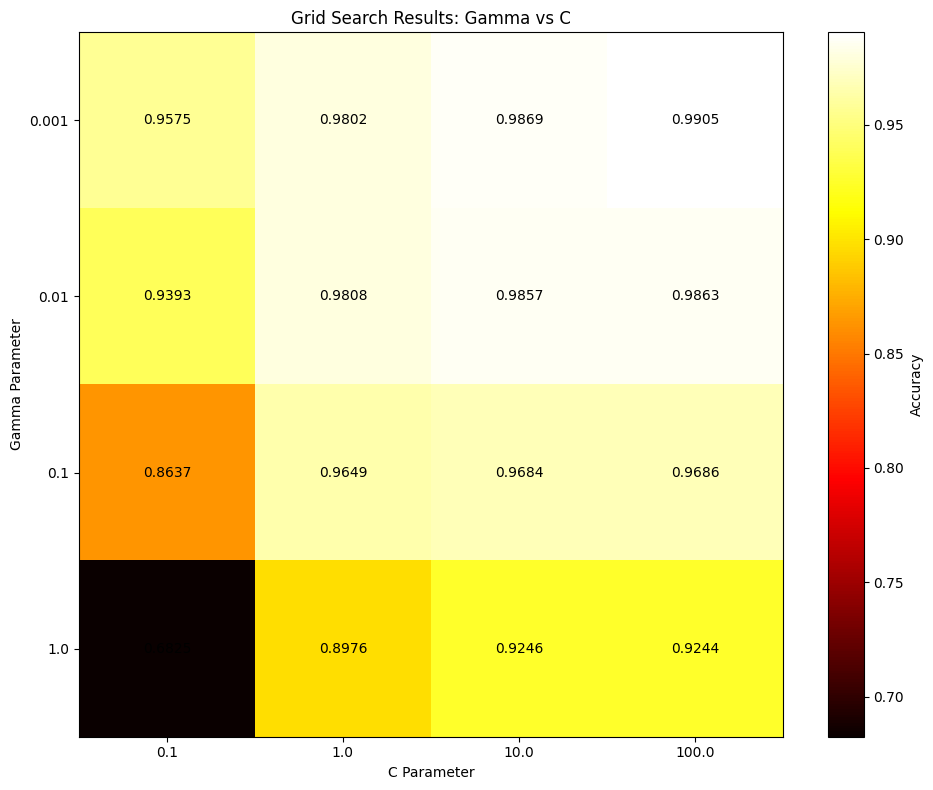

In [ ]:
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['accuracy'].idxmax()]

print("\nBest parameters:")
print(f"Gamma: {best_result['gamma']}")
print(f"C: {best_result['C']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")

# Plot heatmap of results
pivot_table = results_df.pivot(index='gamma', columns='C', values='accuracy')
plt.figure(figsize=(10, 8))
plt.imshow(pivot_table, cmap='hot', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.title('Grid Search Results: Gamma vs C')
plt.xlabel('C Parameter')
plt.ylabel('Gamma Parameter')
plt.xticks(range(len(C_values)), C_values)
plt.yticks(range(len(gamma_values)), gamma_values)

# Add text annotations
for i in range(len(gamma_values)):
    for j in range(len(C_values)):
        plt.text(j, i, f"{pivot_table.iloc[i, j]:.4f}", 
                    ha="center", va="center", color="black")

plt.tight_layout()
plt.show()